# **Sarcasm Detection in Headlines (SWSW-SD)**

In this project, we aim to develop a robust model for detecting sarcasm in headlines using Natural Language Processing (NLP) techniques. Our approach involved a structured workflow that included:




* Data Exploration and Preprocessing
  - We explored and prepared a dataset of headlines, ensuring it was suitable for analysis.
* Feature Extraction Methods
  - Several feature extraction techniques were evaluated to capture relevant information from text, including Bag Of Words, TF-IDF and different word embeddings.
* Classifier and Dimensionality Reduction Evaluation
  - We experimented with 30 combinations of classifiers and dimensionality reduction techniques (such as PCA and LDA) to identify the most effective models
* Model Selection and Hyperparameter Tuning
  - Through hyperparameter tuning, we refined our chosen classifier to maximize predictive accuracy.
* Integration of Large Language Model from HuggingFace
  - Additionally, we explored the integration of pre-trained language models from Hugging Face.



In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import warnings
import itertools
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from collections import Counter

import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, recall_score,
                             matthews_corrcoef, accuracy_score, roc_curve, precision_recall_curve,
                             confusion_matrix)
from sklearn.model_selection import (learning_curve, validation_curve, train_test_split, KFold,
                                     StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV,
                                     cross_validate, RepeatedStratifiedKFold)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, MinMaxScaler)
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
warnings.simplefilter("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
dataset_path = 'Sarcasm_Headlines_Dataset_v2.json'

# Import Datase

In [5]:
df = pd.read_json(dataset_path, lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
#Check if there are missing values
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
#Drop duplicates values
duplicate_count = df.duplicated().sum()
print("duplicates before", duplicate_count)

df.drop_duplicates(inplace=True)
duplicate_count = df.duplicated().sum()
print("duplicates after",  duplicate_count)


duplicates before 2
duplicates after 0


### Drop columns we do not need

In [8]:
df.drop('article_link', axis=1, inplace=True)

In [9]:
df.reset_index(drop=True, inplace=True)

### Expanding Contractions

In [10]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [11]:
text = "I'm happy, because I don't know if it'll rain."
expanded_text = expand_contractions(text)
print(expanded_text)

I am happy, because I do not know if it will rain.


# Text Cleaning and Preprocessing

In [12]:
#Add addionatioal characters found during programming
additional_chars = {"’", "“", "”", "'"}
chars_to_remove = string.punctuation + "".join(str(char) for char in additional_chars)

def process_text(text):
    expanded_text = expand_contractions(text)
    return expanded_text

def remove_punctuation(text):
    text_toInsert = "".join([char for char in text if char not in chars_to_remove])
    return text_toInsert.lower()

def tokenize(text):
    text = word_tokenize(text)
    return text

def remove_stopwords(text):
    text = [word for word in text if word not in stop_words]
    return text

def lemmatization(text):
    return [lemmatizer.lemmatize(word) for word in text]

In [13]:
def process_text(text):
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatization(text)
    return text

### Apply transformation to headline

In [14]:
print("apply process_text to headline data")
df['processed'] = df['headline'].apply(lambda x:process_text(x))
df['sentence'] = df.processed.apply(lambda x: ' '.join(x))

apply process_text to headline data


In [15]:
df.head()

,is_sarcastic,headline,processed,sentence
0,1,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientist, unveil, doomsday,...",thirtysomething scientist unveil doomsday cloc...
1,0,dem rep. totally nails why congress is falling...,"[dem, rep, totally, nail, congress, falling, s...",dem rep totally nail congress falling short ge...
2,0,eat your veggies: 9 deliciously different recipes,"[eat, veggie, 9, deliciously, different, recipe]",eat veggie 9 deliciously different recipe
3,1,inclement weather prevents liar from getting t...,"[inclement, weather, prevents, liar, getting, ...",inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,"[mother, come, pretty, close, using, word, ist...",mother come pretty close using word istreaming...


# Dataset informations

In [17]:
#We add a wordcount column
df['WordCount'] = df['headline'].apply(lambda x: len(x.split()))

total_headlines = len(df)

# Number of sarcastic and non-sarcastic headlines
num_sarcastic = len(df[df['is_sarcastic'] == 1])
num_non_sarcastic = len(df[df['is_sarcastic'] == 0])

# Average word count
avg_word_count = df['WordCount'].mean()
avg_word_count_sarcastic = df[df['is_sarcastic'] == 1]['WordCount'].mean()
avg_word_count_non_sarcastic = df[df['is_sarcastic'] == 0]['WordCount'].mean()

In [18]:
print(f"Total number of headlines: {total_headlines}")
print(f"Number of sarcastic headlines: {num_sarcastic}")
print(f"Number of non-sarcastic headlines: {num_non_sarcastic}")
print(f"Average word count: {avg_word_count:.2f}")
print(f"Average word count (sarcastic): {avg_word_count_sarcastic:.2f}")
print(f"Average word count (non-sarcastic): {avg_word_count_non_sarcastic:.2f}")

Total number of headlines: 28617
Number of sarcastic headlines: 13633
Number of non-sarcastic headlines: 14984
Average word count: 10.05
Average word count (sarcastic): 10.31
Average word count (non-sarcastic): 9.82


# **Data Visualization**

### Visualize the frequency of the top 20 words for both Sarcastic and Not_Sarcastic Headlines

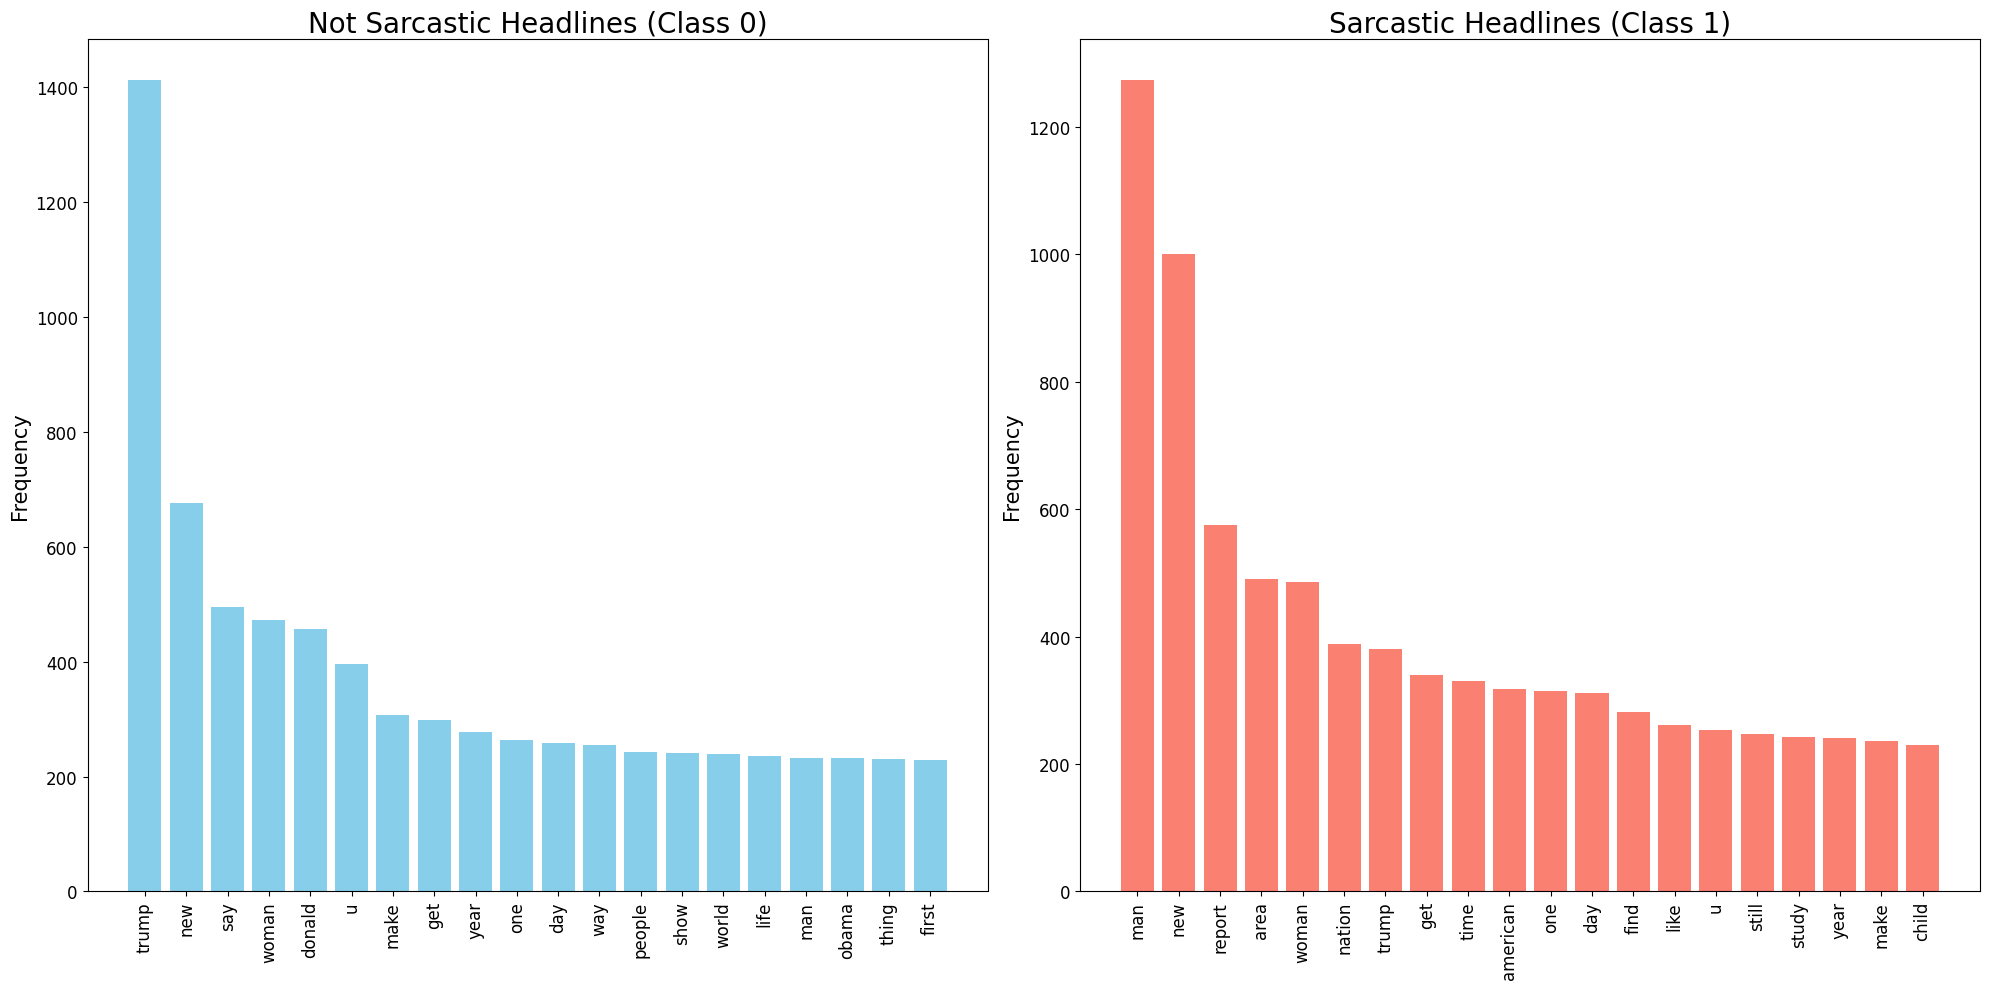

In [19]:
grouped = df.groupby('is_sarcastic')
top_n = 20
num_class = len(grouped)
num_cols = 2
num_rows = (num_class + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 10))  # Increase figure size
axes = axes.flatten()

colors = {0: '#87CEEB', 1: '#FA8072'}

for i, (clas, group) in enumerate(grouped):
    if i >= len(axes):
        break
    sarcastic_tokens = group['processed'].sum()
    word_freq = Counter(sarcastic_tokens)
    top_words = dict(word_freq.most_common(top_n))
    ax = axes[i]
    ax.bar(top_words.keys(), top_words.values())

    bar_colors = [colors[clas]] * len(top_words)
    ax.bar(top_words.keys(), top_words.values(), color=bar_colors)

    #CHATGPT: in the set title can you add the fact that if 0 then is not sarcastic if 1 is sarcastic
    title = 'Sarcastic' if clas == 1 else 'Not Sarcastic'
    ax.set_title(f'{title} Headlines (Class {clas})', fontsize=20)

    ax.set_ylabel('Frequency', fontsize=15)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.xaxis.set_tick_params(rotation=90)
    ax.grid(False)

# Hide empty subplots if there are any
for i in range(num_class, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Visualization of length of headlines

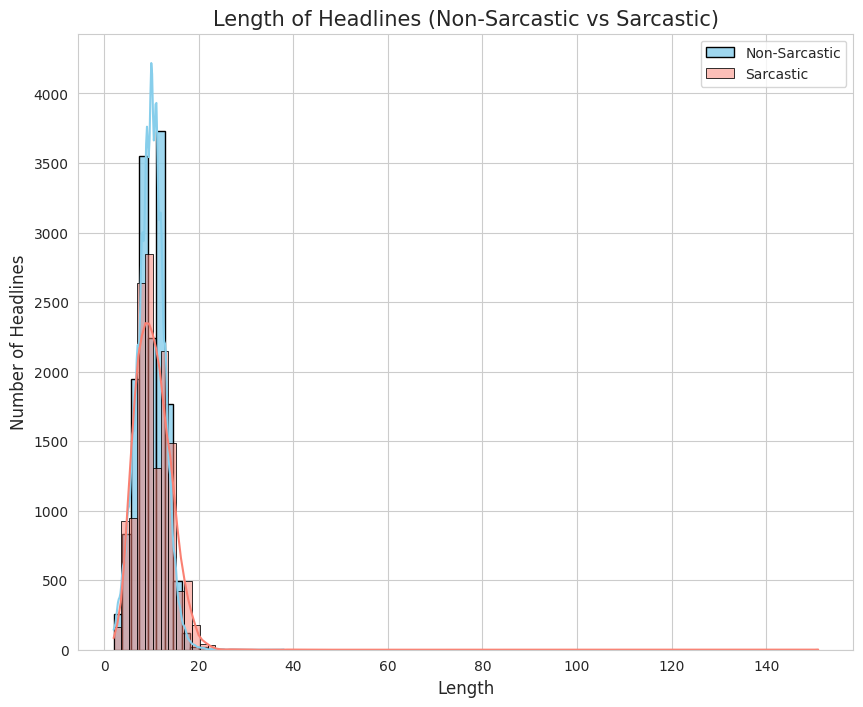

In [20]:
#CHATGPT:
  #I have a df of headlines and
  #a Is_sarcastc column. Make 2 graphs one for the non sarcastic
  #headlines and one for the sarcastic headline thanks!

non_sarcastic = df[df['is_sarcastic'] == 0]
sarcastic = df[df['is_sarcastic'] == 1]

sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
plt.title('Length of Headlines (Non-Sarcastic vs Sarcastic)', fontsize=15)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Number of Headlines", fontsize=12)

sns.histplot(non_sarcastic['WordCount'], kde=True, bins=20, color='skyblue', edgecolor='black', label='Non-Sarcastic', alpha=0.8)

sns.histplot(sarcastic['WordCount'], kde=True, bins=90, color='salmon', edgecolor='black', label='Sarcastic', alpha=0.5)

plt.legend()

plt.show()

### The dataset is Balanced

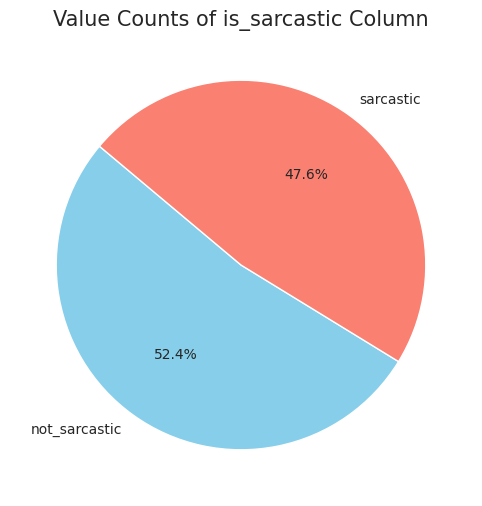

In [21]:
#CHATGPT:
  #Can you make this a piechart please

value_counts = df['is_sarcastic'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(value_counts, labels=['not_sarcastic', 'sarcastic'], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])

plt.title('Value Counts of is_sarcastic Column', fontsize=15)

plt.show()

### Visualization of top-10 2-grams for both Sarcastic and Not Sarcastic headlines

In [22]:
#CHATGPT:
  #I have this code to plot the top n grams of the headlines,
  #can you also create 2 plots to show the n grams in the sarcastic headlines
  #and non sarcastic headlines thanks!

def plot_top_ngrams_barchart(ax, text, n=2, title='', colors=None):
    new = text.str.split()
    new = new.values.tolist()

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(text, n)[:10]
    x, y = map(list, zip(*top_n_bigrams))

    if colors:
        sns.barplot(ax=ax, x=y, y=x, palette=colors)
    else:
        sns.barplot(ax=ax, x=y, y=x)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Frequency', fontsize=12)

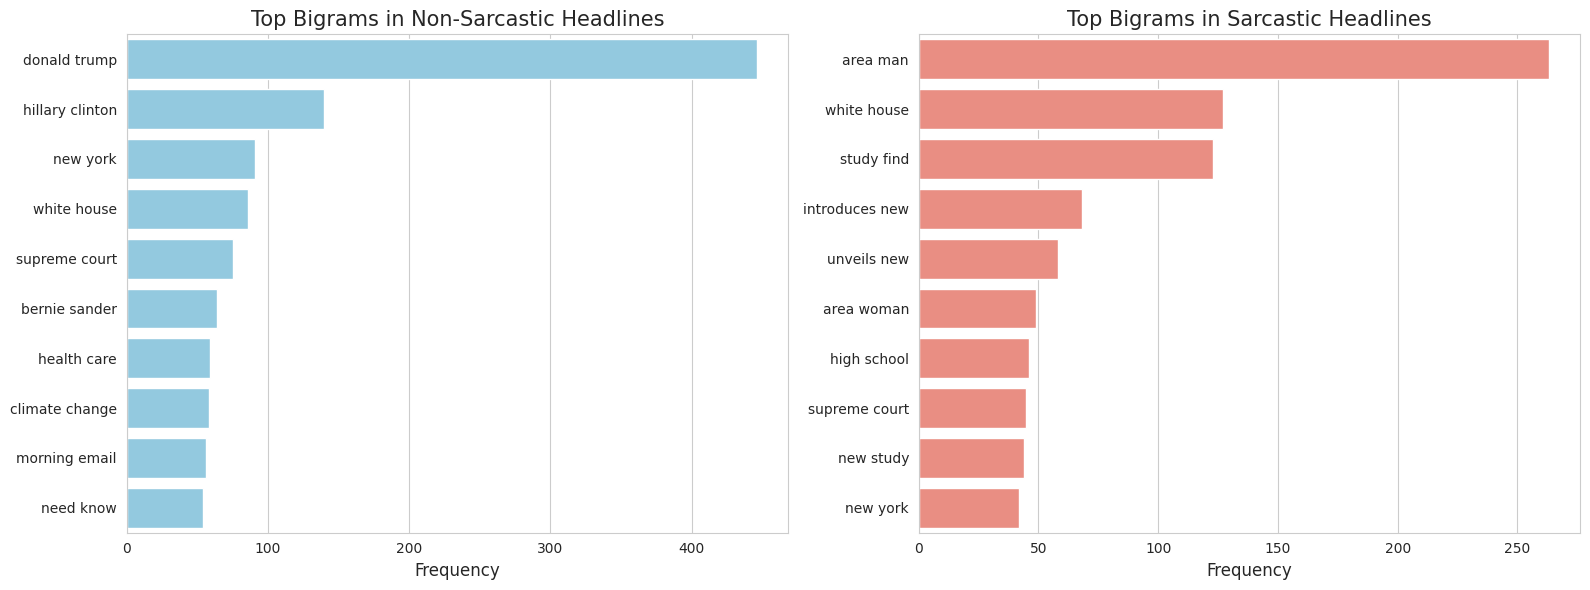

In [23]:
#CHATGPT: Can you please change the color of this 2 barplots to #87CEEB, #FA8072

colors_non_sarcastic = ['#87CEEB']  # Skyblue for non-sarcastic headlines
colors_sarcastic = ['#FA8072'] # Salmon for sarcastic headlines

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

plot_top_ngrams_barchart(ax=axes[0], text=non_sarcastic['sentence'], n=2, title='Top Bigrams in Non-Sarcastic Headlines', colors=colors_non_sarcastic)

plot_top_ngrams_barchart(ax=axes[1], text=sarcastic['sentence'], n=2, title='Top Bigrams in Sarcastic Headlines', colors=colors_sarcastic)

plt.tight_layout()

plt.show()

# **Feature extraction methods**

We are going to try feature extraction methods of word representation and test them with a genral classifier like logisticRegression, in this way we can understand which is the best representation method.

In [24]:
df.head()

,is_sarcastic,headline,processed,sentence,WordCount
0,1,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientist, unveil, doomsday,...",thirtysomething scientist unveil doomsday cloc...,8
1,0,dem rep. totally nails why congress is falling...,"[dem, rep, totally, nail, congress, falling, s...",dem rep totally nail congress falling short ge...,13
2,0,eat your veggies: 9 deliciously different recipes,"[eat, veggie, 9, deliciously, different, recipe]",eat veggie 9 deliciously different recipe,7
3,1,inclement weather prevents liar from getting t...,"[inclement, weather, prevents, liar, getting, ...",inclement weather prevents liar getting work,8
4,1,mother comes pretty close to using word 'strea...,"[mother, come, pretty, close, using, word, ist...",mother come pretty close using word istreaming...,9


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['is_sarcastic'], test_size=0.2, random_state=42)

In [119]:
accuracies = {}

# **Bag Of Word** *(Logisticregression)*

In [120]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Feature extraction using Bag-of-Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Model training
model_bow = LogisticRegression()
model_bow.fit(X_train_bow, y_train)

# Evaluation
y_pred_bow = model_bow.predict(X_test_bow)
print("Bag-of-Words Performance:")
print(classification_report(y_test, y_pred_bow))

accuracy_bow = accuracy_score(y_test, y_pred_bow)
accuracies['Bag of Words'] = accuracy_bow

Bag-of-Words Performance:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3007
           1       0.79      0.75      0.77      2717

    accuracy                           0.79      5724
   macro avg       0.79      0.78      0.79      5724
weighted avg       0.79      0.79      0.79      5724



# **TF-IDF Vectorizer** (*Logisticregression*)

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model training
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train)

# Evaluation
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print("TF-IDF Performance:")
print(classification_report(y_test, y_pred_tfidf))

accuracy_Tfid = accuracy_score(y_test, y_pred_tfidf)
accuracies['TF-IDF Vectorizer'] = accuracy_Tfid


TF-IDF Performance:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      3007
           1       0.79      0.74      0.77      2717

    accuracy                           0.79      5724
   macro avg       0.79      0.78      0.79      5724
weighted avg       0.79      0.79      0.79      5724



# **Word2Vec**

In [30]:
sentences_processed = df['processed']

In [31]:
from gensim.models import Word2Vec

# Creating the Word2Vec model
w2v = Word2Vec(sentences_processed, vector_size=100, window=5, workers=4, epochs=10, min_count=5)

In [32]:
print(w2v.wv['computer'])

[-0.12546712  0.3356764   0.16118793  0.07174397  0.05701207 -0.45253643
  0.17265226  0.61559105 -0.19744124 -0.12794356 -0.23695987 -0.53473794
  0.03604902  0.05936439  0.15519556 -0.28280306  0.08443624 -0.24626124
  0.09924663 -0.58364004  0.18058842  0.06544562  0.2749978  -0.06510541
 -0.05795861 -0.00193709 -0.1306818  -0.22638302 -0.23244812  0.06096937
  0.33456865  0.07905962 -0.01765331 -0.13238823 -0.00190919  0.21064699
 -0.01269843 -0.24050646 -0.19056821 -0.44807607  0.05421152 -0.30457693
 -0.07133812  0.03642739  0.14023775 -0.15001783 -0.23759136  0.05164541
  0.03604842  0.24980322  0.13591659 -0.24328487 -0.22915272 -0.1266224
 -0.2413986   0.1235453   0.14541785 -0.02340355 -0.36549926  0.05792445
  0.1103947   0.04065554 -0.00840706  0.12039965 -0.31269568  0.34616962
  0.0703264   0.1835952  -0.28458124  0.31941226 -0.1463585   0.18546683
  0.29224563 -0.16851965  0.22336052  0.16876653  0.05301166  0.02594411
 -0.2639549   0.09330288 -0.14170116 -0.01619581 -0.

In [33]:
w2v.wv.similarity("donald", "trump")

0.35672754

In [34]:
w2v.wv.similarity("dad", "father")

0.9100322

In [35]:
w2v.wv.most_similar("man")

[('woman', 0.9397732019424438),
 ('dad', 0.8615298271179199),
 ('mom', 0.7767627239227295),
 ('teen', 0.7589141130447388),
 ('family', 0.7450379729270935),
 ('mother', 0.7407966256141663),
 ('see', 0.7368962168693542),
 ('couple', 0.73542720079422),
 ('friend', 0.7309209704399109),
 ('bug', 0.727914571762085)]

### Predict *(LogisticRegression)*

In [36]:
def get_sentence_vector_w2v(sentence, model):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(model.wv[words], axis=0)

In [37]:
X_w2v = np.array([get_sentence_vector_w2v(sentence, w2v) for sentence in sentences_processed])
y_w2v = df['is_sarcastic'].values

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=42)

In [122]:
classifier_w2v = LogisticRegression()
classifier_w2v.fit(X_train_w2v, y_train_w2v)

y_pred_w2v = classifier_w2v.predict(X_test_w2v)

# Evaluating the model
accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
print(classification_report(y_test_w2v, y_pred_w2v))


accuracies['Word2Vec'] = accuracy_w2v

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      3007
           1       0.67      0.62      0.64      2717

    accuracy                           0.67      5724
   macro avg       0.67      0.67      0.67      5724
weighted avg       0.67      0.67      0.67      5724



# **FastText**

In [41]:
from gensim.models import FastText

fasttext_model = FastText(sentences_processed, vector_size=100, window=5, min_count=1, workers=6, epochs=10)

In [42]:
print(fasttext_model.wv['computer'])

[-3.00084323e-01  5.15652061e-01 -5.50095260e-01  3.75397056e-01
  4.01825219e-01  6.86122999e-02  7.37088099e-02  1.65367767e-01
  5.59725642e-01 -6.68676019e-01 -3.87258798e-01 -1.85396656e-01
 -4.00709331e-01  7.05344319e-01 -1.22010289e-02 -2.08431914e-01
 -1.52115509e-01 -3.20742995e-01 -6.44865513e-01 -8.57222259e-01
 -7.44357169e-01  2.93660313e-02 -1.59233361e-01 -2.47767344e-01
 -1.58219516e-01 -3.99746329e-01 -3.61841977e-01  2.17494115e-01
  6.76625788e-01 -1.49350286e-01 -1.96246982e-01  2.33667210e-01
  3.61921310e-01 -2.70544410e-01 -3.20099025e-05  2.12247401e-01
  3.46254021e-01  7.06753612e-01 -5.74270070e-01  3.91993970e-01
  5.02138436e-01 -6.83932126e-01 -1.17911905e-01 -4.25060898e-01
 -6.13210320e-01 -1.71891779e-01 -1.15369625e-01 -4.12157506e-01
  9.85799208e-02  1.04938366e-01 -5.31660654e-02  2.70780362e-02
  7.21181810e-01  4.64377522e-01  2.41363514e-02 -3.08474332e-01
 -5.46942651e-01  3.76871191e-02 -1.95771694e-01 -7.64984591e-03
  6.05455101e-01 -3.53985

In [43]:
fasttext_model.wv.similarity("donald", "trump")

0.5779619

In [44]:
fasttext_model.wv.similarity("dad", "father")


0.95372915

In [48]:
fasttext_model.wv.most_similar("father")

[('bother', 0.9987280368804932),
 ('motherfker', 0.9984317421913147),
 ('brother', 0.9980923533439636),
 ('fatherdaughter', 0.9978406429290771),
 ('godfather', 0.9975440502166748),
 ('motherfucker', 0.9975312352180481),
 ('godmother', 0.9975300431251526),
 ('grandmother', 0.9973798394203186),
 ('daughter', 0.9969684481620789),
 ('together', 0.9966080188751221)]

### Predict *(LogisticRegression)*

In [49]:
def get_sentence_vector_fT(sentence, model):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean([model.wv[word] for word in words], axis=0)

In [50]:
X_fT = np.array([get_sentence_vector_fT(sentence, fasttext_model) for sentence in sentences_processed])
y_fT = df['is_sarcastic'].values

# Splitting the data into train and test sets
X_train_fT, X_test_fT, y_trainfT, y_testfT = train_test_split(X_fT, y_fT, test_size=0.2, random_state=42)

In [123]:
classifier_fT = LogisticRegression()
classifier_fT.fit(X_train_fT, y_trainfT)

y_pred_fT = classifier_fT.predict(X_test_fT)

accuracy_fT = accuracy_score(y_testfT, y_pred_fT)
print(classification_report(y_testfT, y_pred_fT))

accuracies['FastText'] = accuracy_fT

              precision    recall  f1-score   support

           0       0.64      0.71      0.67      3007
           1       0.64      0.56      0.60      2717

    accuracy                           0.64      5724
   macro avg       0.64      0.64      0.64      5724
weighted avg       0.64      0.64      0.64      5724



# **Bag Of Words** + **TF-TDF**

In [56]:
X_BWT = df['sentence']
y_BWT = df['is_sarcastic']
x_train_BWT, x_test_BWT, y_train_BWT, y_test_BWT = train_test_split(X_BWT, y_BWT, test_size=0.2, random_state=42)

In [57]:
#first we need to define the vocabulary using the training data only!
vocab_BWT = set()
for sent in x_train_BWT:
    for word in sent.split(" "):
        vocab_BWT.add(word.strip())

print(len(vocab_BWT))

23093


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

documents_train_BWT = list(x_train_BWT)
documents_test_BWT = list(x_test_BWT)

# tfidf for the training data
vectorizer_BWT = CountVectorizer(vocabulary= vocab_BWT)
X_count_train_BWT = vectorizer_BWT.fit_transform(documents_train_BWT)

transformer_BWT = TfidfTransformer()
X_tfidf_train_BWT = transformer_BWT.fit_transform(X_count_train_BWT)

# tfidf for the testing data
X_count_test_BWT = vectorizer_BWT.transform(documents_test_BWT)
X_tfidf_test_BWT = transformer_BWT.transform(X_count_test_BWT)

### Predict *(LogistcRegression)*

In [124]:
model_BWT = LogisticRegression()
model_BWT.fit(X_tfidf_train_BWT, y_train_BWT)

# Evaluation
y_pred_BWT = model_BWT.predict(X_tfidf_test_BWT)

print("TF-IDF + BoW Performance:")
print(classification_report(y_test_BWT, y_pred_BWT))

accuracy_BWT = accuracy_score(y_test_BWT, y_pred_BWT)
accuracies['BOW + TF-TDF'] = accuracy_BWT

TF-IDF + BoW Performance:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3007
           1       0.80      0.76      0.78      2717

    accuracy                           0.80      5724
   macro avg       0.80      0.80      0.80      5724
weighted avg       0.80      0.80      0.80      5724



# **GloVe Embeddings**

In [60]:
import gensim.downloader as api

# Load GloVe pre-trained embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [61]:
X_GlE = df['sentence']
y_GlE = df['is_sarcastic']
X_train_GlE, X_test_GlE, y_train_GlE, y_test_GlE = train_test_split(X_GlE, y_GlE, test_size=0.2, random_state=42)

documents_train_GlE = list(X_train_GlE)
documents_test_GlE = list(X_test_GlE)

tokenized_train_GlE = [doc.split() for doc in documents_train_GlE]
tokenized_test_GlE = [doc.split() for doc in documents_test_GlE]


In [62]:
def get_document_embedding_GlE(tokens, model, embedding_dim=100):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

embedding_dim = 100

# Get embeddings for each document
train_embeddings_GlE = [get_document_embedding_GlE(doc, glove_vectors, embedding_dim) for doc in tokenized_train_GlE]
test_embeddings_GlE = [get_document_embedding_GlE(doc, glove_vectors, embedding_dim) for doc in tokenized_test_GlE]

In [63]:
X_train_GlE = np.array(train_embeddings_GlE)
X_test_GlE = np.array(test_embeddings_GlE)

### Presict *(LogisticRegression)*

In [125]:
classfiers_GlE = LogisticRegression()
classfiers_GlE.fit(X_train_GlE, y_train_GlE)

# Evaluation
y_pred_GlE = classfiers_GlE.predict(X_test_GlE)

print("Glove Embedding Performance:")
print(classification_report(y_test_GlE, y_pred_GlE))

accuracy_GLE = accuracy_score(y_test_GlE, y_pred_GlE)
accuracies['GloVe'] = accuracy_GLE

Glove Embedding Performance:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      3007
           1       0.68      0.66      0.67      2717

    accuracy                           0.69      5724
   macro avg       0.69      0.69      0.69      5724
weighted avg       0.69      0.69      0.69      5724



# **BERT**

In [65]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [66]:
import accelerate
import transformers
#versions must be ('4.41.2', '0.31.0') respectlivy
transformers.__version__, accelerate.__version__

('4.41.2', '0.31.0')

In [67]:
# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['headline'], df['is_sarcastic'], test_size=0.2, random_state=42
)

In [68]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import logging as transformers_logging
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
transformers_logging.set_verbosity_error()


#Tokenizer and Model Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts.iloc[index]
        label = self.labels.iloc[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#We create a dataset object
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

#Fine-tune BERT
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [69]:
trainer.train()

{'loss': 0.4421, 'grad_norm': 26.339387893676758, 'learning_rate': 5e-05, 'epoch': 0.17470300489168414}
{'loss': 0.3728, 'grad_norm': 18.100242614746094, 'learning_rate': 4.5214395099540586e-05, 'epoch': 0.3494060097833683}
{'loss': 0.326, 'grad_norm': 8.291799545288086, 'learning_rate': 4.042879019908117e-05, 'epoch': 0.5241090146750524}
{'loss': 0.29, 'grad_norm': 20.004663467407227, 'learning_rate': 3.564318529862175e-05, 'epoch': 0.6988120195667366}
{'loss': 0.2967, 'grad_norm': 20.63216209411621, 'learning_rate': 3.085758039816233e-05, 'epoch': 0.8735150244584207}
{'loss': 0.2355, 'grad_norm': 0.07859254628419876, 'learning_rate': 2.607197549770291e-05, 'epoch': 1.0482180293501049}
{'loss': 0.1534, 'grad_norm': 0.05374713987112045, 'learning_rate': 2.1286370597243495e-05, 'epoch': 1.2229210342417889}
{'loss': 0.144, 'grad_norm': 0.13820181787014008, 'learning_rate': 1.6500765696784072e-05, 'epoch': 1.397624039133473}
{'loss': 0.1555, 'grad_norm': 32.82060241699219, 'learning_rate'

TrainOutput(global_step=5724, training_loss=0.23765521479352716, metrics={'train_runtime': 1358.3301, 'train_samples_per_second': 33.708, 'train_steps_per_second': 4.214, 'train_loss': 0.23765521479352716, 'epoch': 2.0})

In [70]:
import joblib

def get_bert_embeddings(texts, tokenizer, model, max_len=128, device='cuda', batch_size=8):
    model.to(device)  # Move model to the specified device
    model.eval()

    all_cls_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=max_len)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the specified device

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states
        # Use the embeddings of the [CLS] token (first token)
        cls_embeddings = hidden_states[-1][:, 0, :].cpu().numpy()  # Move embeddings back to CPU for further processing
        all_cls_embeddings.append(cls_embeddings)

    all_cls_embeddings = np.concatenate(all_cls_embeddings, axis=0)
    return all_cls_embeddings


device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_embeddings = get_bert_embeddings(train_texts, tokenizer, model, device=device, batch_size=8)

np.save('train_embeddings_BERT.npy', train_embeddings)  # Save train embeddings

#save_path_train = '/content/drive/MyDrive/Colab_Notebooks/NLP/Project/GOOD/train_embeddings_BERT.npy'
joblib.dump(train_embeddings, 'train_embeddings_BERT.npy')

test_embeddings = get_bert_embeddings(test_texts, tokenizer, model, device=device, batch_size=8)
np.save('test_embeddings_BERT.npy', test_embeddings)  # Save test embeddings

#save_path_test = '/content/drive/MyDrive/Colab_Notebooks/NLP/Project/GOOD/test_embeddings_BERT.npy'
joblib.dump(test_embeddings, 'test_embeddings_BERT.npy')


['test_embeddings_BERT.npy']

In [71]:
import numpy as np
import joblib
#save_path_train = '/content/drive/MyDrive/Colab_Notebooks/NLP/Project/GOOD/train_embeddings_BERT.npy'
#save_path_test = '/content/drive/MyDrive/Colab_Notebooks/NLP/Project/GOOD/test_embeddings_BERT.npy'

# Load the saved embeddings
train_embeddings_BERT = joblib.load('train_embeddings_BERT.npy')
test_embeddings_BERT = joblib.load('test_embeddings_BERT.npy')

# Verify the shapes
print('Train embeddings shape:', train_embeddings_BERT.shape)
print('Test embeddings shape:', test_embeddings_BERT.shape)


Train embeddings shape: (22893, 768)
Test embeddings shape: (5724, 768)


### **Predict** *(LogisticRegression + l2 regularization)*

In [126]:
from sklearn.metrics import classification_report
# Logistic Regression
classifier_BERT= LogisticRegression(max_iter=1000, C=0.01, penalty='l2')
classifier_BERT.fit(train_embeddings_BERT, train_labels)

# Predict and Evaluate
test_preds_BERT = classifier_BERT.predict(test_embeddings_BERT)
print("FineTunign BERT Performance:")
print(classification_report(test_labels, test_preds_BERT))

accuracy_BERT = accuracy_score(test_labels, test_preds_BERT)
accuracies['BERT'] = accuracy_BERT

FineTunign BERT Performance:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3007
           1       0.93      0.94      0.93      2717

    accuracy                           0.94      5724
   macro avg       0.94      0.94      0.94      5724
weighted avg       0.94      0.94      0.94      5724



###Accuracies of all of them compared

In [127]:
from tabulate import tabulate

df_accuracies = pd.DataFrame(list(accuracies.items()), columns=['Feature Extraction Method', 'Accuracy'])
df_accuracies = df_accuracies.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

df_accuracies.index += 1
df_accuracies.index.name = 'No.'

print(tabulate(df_accuracies, headers='keys', tablefmt='fancy_grid'))

╒═══════╤═════════════════════════════╤════════════╕
│   No. │ Feature Extraction Method   │   Accuracy │
╞═══════╪═════════════════════════════╪════════════╡
│     1 │ BERT                        │   0.937456 │
├───────┼─────────────────────────────┼────────────┤
│     2 │ BOW + TF-TDF                │   0.797869 │
├───────┼─────────────────────────────┼────────────┤
│     3 │ Bag of Words                │   0.786688 │
├───────┼─────────────────────────────┼────────────┤
│     4 │ TF-IDF Vectorizer           │   0.786513 │
├───────┼─────────────────────────────┼────────────┤
│     5 │ GloVe                       │   0.69427  │
├───────┼─────────────────────────────┼────────────┤
│     6 │ Word2Vec                    │   0.67348  │
├───────┼─────────────────────────────┼────────────┤
│     7 │ FastText                    │   0.640636 │
╘═══════╧═════════════════════════════╧════════════╛


Clearly we can see that the bert embeddings are the best, we are going to use those for a machine leanring algorithm

Now we can try both a Neural Network and a machine learning classifier, using cross validation, RandomSearchCV and hyperparameter tyning we can select the best one

# **Find the best combination of Machine Learning Algorithms**

### Sanity check

In [89]:
model_p = Pipeline(
    steps=[
        ('dim_reduction', TruncatedSVD()),  # Dimensionality reduction technique
        ('classifier', LogisticRegression(max_iter=1000, C=0.01, penalty='l2'))  # Classifier
    ],
    verbose=False
)

In [90]:
model_p.fit(train_embeddings_BERT, train_labels)

Pipeline(steps=[('dim_reduction', TruncatedSVD()),
                ('classifier', LogisticRegression(C=0.01, max_iter=1000))])

In [91]:
model_p.predict(test_embeddings_BERT)

array([0, 1, 1, ..., 0, 0, 1])

### Dict of all possible combinations

In [92]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [TruncatedSVD()],
        'dim_reduction__n_components': [5, 50, 100]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [5, 50, 100]
    },
    {
        'dim_reduction': [TSNE()],
        'dim_reduction__n_components': [2, 3]
    },
    {
        'dim_reduction': [LinearDiscriminantAnalysis()],
        'dim_reduction__n_components': [1]
    }
]

estimator_configs = [
    {
        'classifier': [LinearSVC()],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 9]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100, 500]
    },
    {
        'classifier': [OneVsOneClassifier(LinearSVC())],
        'classifier__estimator__C': [0.1, 1.0, 10.0]
    },
    {
        'classifier': [OneVsRestClassifier(LinearSVC())],
        'classifier__estimator__C': [0.1, 1.0, 10.0]
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
]


In [93]:
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(dim_reduction_configs, estimator_configs)]

### All Possible Combinations

In [94]:
len(all_configs)

30

### Perform a RandomizesSearchCV and Cross validation

In [95]:
rs= RandomizedSearchCV(model_p,
    param_distributions= all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring= 'f1'
)

In [96]:
scores = cross_validate(rs, train_embeddings_BERT, train_labels, scoring = 'f1', cv=5, return_estimator=True, verbose=3)

[CV] END ......................................., score=0.962 total time= 9.3min
[CV] END ......................................., score=0.990 total time=21.4min
[CV] END ......................................., score=0.991 total time=10.9min
[CV] END ......................................., score=0.989 total time=11.1min
[CV] END ......................................., score=0.989 total time=13.2min


In [99]:
best_index = None
best_score = -1

for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'], estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*20)

    if scores['test_score'][index] > best_score:
        best_score = scores['test_score'][index]
        best_index = index

print(f"Best score: {best_score} at index: {best_index}")


PCA(n_components=5)
OneVsOneClassifier(estimator=LinearSVC(C=10.0)) {'estimator__C': 10.0, 'estimator__class_weight': None, 'estimator__dual': True, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__multi_class': 'ovr', 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator': LinearSVC(C=10.0), 'n_jobs': None}
0.9615019011406845
--------------------
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9903802107191938
--------------------
PCA(n

### Save the model

In [100]:
import joblib
if best_index is not None:
    best_estimator = scores['estimator'][best_index].best_estimator_
    save_path = 'best_model.pkl'
    joblib.dump(best_estimator, save_path)
    print(f"Best model saved as '{save_path}'")
else:
    print("No best model found.")

Best model saved as 'best_model.pkl'


In [101]:
best_estimator = joblib.load('best_model.pkl')

In [102]:
from sklearn.metrics import f1_score

# Evaluate the best estimators on the training and test sets
for index, estimator in enumerate(scores['estimator']):
    # Refit the model on the entire training set
    best_model_BERT = estimator.best_estimator_.fit(train_embeddings_BERT, train_labels)

    # Predict on training and test data
    pred_train_BERT = best_model_BERT.predict(train_embeddings_BERT)
    pred_test_BERT = best_model_BERT.predict(test_embeddings_BERT)

    # Calculate F1 scores
    f1_train_BERT = f1_score(train_labels, pred_train_BERT)
    f1_test_BERT = f1_score(test_labels, pred_test_BERT)

    # Print the F1 scores
    print(f'F1 Score on training set: {f1_train_BERT:.4f}, F1 Score on test set: {f1_test_BERT:.4f}')

    # Print the cross-validation test score from RandomizedSearchCV
    print(f'Cross-validated F1 Score: {scores["test_score"][index]:.4f}')
    print('-'*20)


F1 Score on training set: 0.9907, F1 Score on test set: 0.9335
Cross-validated F1 Score: 0.9615
--------------------
F1 Score on training set: 1.0000, F1 Score on test set: 0.9348
Cross-validated F1 Score: 0.9904
--------------------
F1 Score on training set: 0.9914, F1 Score on test set: 0.9337
Cross-validated F1 Score: 0.9908
--------------------
F1 Score on training set: 0.9918, F1 Score on test set: 0.9342
Cross-validated F1 Score: 0.9890
--------------------
F1 Score on training set: 0.9924, F1 Score on test set: 0.9321
Cross-validated F1 Score: 0.9892
--------------------


# Selecting the Best pipeline

In [103]:
best_model_pipeline = Pipeline([
    ('dim_reduction', None),
    ('classifier', RandomForestClassifier(n_estimators=500))
])

### Hyperparametrization tuning

In [104]:
params = {'classifier__bootstrap': [True, False],
          'classifier__ccp_alpha': [0.0],
          'classifier__criterion': ['gini', 'entropy'],
          'classifier__max_depth': [None, 30, 50, 100],
          'classifier__max_features': ['auto', 'sqrt'],
          'classifier__min_samples_leaf': [1, 2],
          'classifier__min_samples_split': [5, 10],
          'classifier__n_estimators': [100, 500, 1000, 1400],
          'classifier__random_state': [42]
}

In [105]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring= 'f1'
)

In [ ]:
rs_best.fit(train_embeddings_BERT, train_labels)

# **Model Evaluation**

In [ ]:
print(f1_score(test_labels, rs_best.best_estimator_.predict(test_embeddings_BERT)))

0.9361075308414656


In [ ]:
best_model = rs_best.best_estimator_

In [ ]:
save_best = 'best_final_model.pkl'
joblib.dump(best_model, save_best)

In [ ]:
best_model = joblib.load('best_final_model.pkl')

### Confusion Matrix

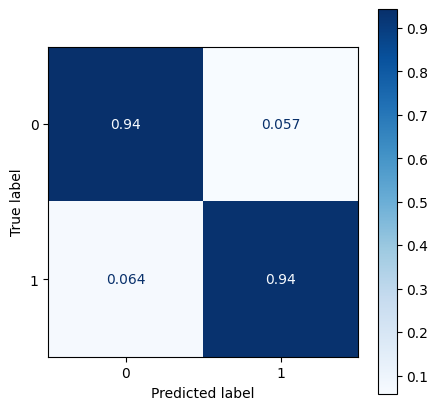

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
cm_display = ConfusionMatrixDisplay.from_estimator(best_model, test_embeddings_BERT, test_labels, normalize='true', ax=ax, cmap='Blues')
plt.show()

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model,
                                                       X=train_embeddings_BERT,
                                                       y=train_labels,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

# **Plotting Learning curve of model**

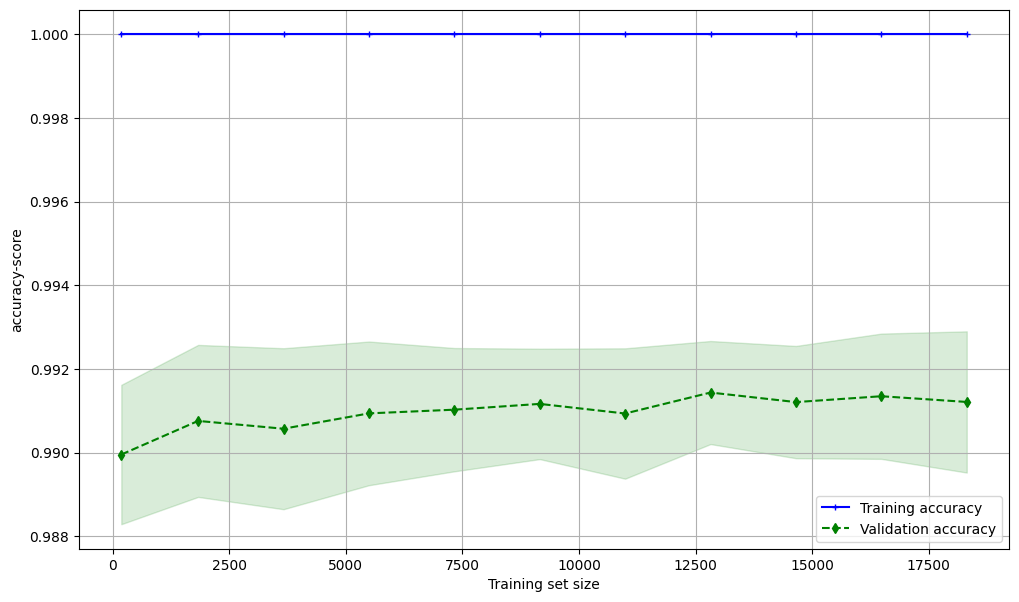

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('accuracy-score')
ax.legend(loc='lower right')

# *Hugging face* - Text Classfication

Fine Tuning the Hugging Face BERT LLMs on out dataset to see how a LLMs.

We fine-tuned the "distilbert-base-cased" using Hugging Face. The following code cannot be run exept from the owner of the account. An additional code to load said model will be avaible below

### Code to show process (*not accessible*)

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [ ]:
import transformers, evaluate, datasets
import pandas as pd

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
from datasets import Dataset

train, test= train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

In [ ]:
train = train.rename_column('headline', 'text')
train = train.rename_column('is_sarcastic', 'label')

test = test.rename_column('headline', 'text')
test = test.rename_column('is_sarcastic', 'label')


In [ ]:
train = train.train_test_split(test_size=0.15)

In [ ]:
train

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 19459
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 3434
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased') #uncase non fa differenza con le maiuscole, cased lo fa

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation = True) #taglia le frasi troppo lunge

In [ ]:
tokenized_train = train.map(preprocess_function, batched = True)
tokenized_test = test.map(preprocess_function, batched = True)

Map:   0%|          | 0/19459 [00:00<?, ? examples/s]

Map:   0%|          | 0/3434 [00:00<?, ? examples/s]

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch]
!pip install accelerate[torch]==0.27.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [97]:
import accelerate
import transformers
#Necessary versions: ('4.41.2', '0.27.2')
transformers.__version__, accelerate.__version__

('4.41.2', '0.31.0')

In [ ]:
training_args = TrainingArguments(
    output_dir="Sarcastic_01",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train["train"],
    eval_dataset=tokenized_train["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.324400,0.226562,0.906814
2,0.183200,0.216712,0.919627
3,0.109200,0.308291,0.921083
4,0.064500,0.403005,0.922248
5,0.023200,0.480705,0.923995
6,0.014100,0.527143,0.920792
7,0.009200,0.535203,0.923995
8,0.006800,0.562992,0.925160
9,0.005400,0.579901,0.923995
10,0.002300,0.586840,0.923413


TrainOutput(global_step=6090, training_loss=0.06447807922653474, metrics={'train_runtime': 703.786, 'train_samples_per_second': 276.49, 'train_steps_per_second': 8.653, 'total_flos': 1439308737848100.0, 'train_loss': 0.06447807922653474, 'epoch': 10.0})

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1718570986.8603748540df.1613.0:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/PietroSaveri/Sarcastic_01/commit/ef471a0eed1765a411dab328c3afb0c2dee3ccc0', commit_message='End of training', commit_description='', oid='ef471a0eed1765a411dab328c3afb0c2dee3ccc0', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="PietroSaveri/Sarcastic_01")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# **CODE to upload the model created above**

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.9 MB/s eta 0:00:00


In [ ]:
from transformers import TextClassificationPipeline


model_name = 'PietroSaveri/Sarcastic_01'

# Load the tokenizer
tokenizer01 = AutoTokenizer.from_pretrained(model_name)

# Load the model
model01 = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = TextClassificationPipeline(model=model01, tokenizer=tokenizer01)

In [ ]:
pred = classifier(test['text'], truncation=True)

In [ ]:
pred[:10]

[{'label': 'LABEL_0', 'score': 0.6705285310745239},
 {'label': 'LABEL_1', 'score': 0.9947407841682434},
 {'label': 'LABEL_1', 'score': 0.997512698173523},
 {'label': 'LABEL_1', 'score': 0.9973646998405457},
 {'label': 'LABEL_0', 'score': 0.997072696685791},
 {'label': 'LABEL_1', 'score': 0.8617116808891296},
 {'label': 'LABEL_0', 'score': 0.9916290044784546},
 {'label': 'LABEL_0', 'score': 0.9950205087661743},
 {'label': 'LABEL_1', 'score': 0.989772379398346},
 {'label': 'LABEL_1', 'score': 0.9970114231109619}]

In [ ]:
#CHATGPT
  #what would be a nice to way to finish this project?
  #maybe a plot of something? maybe a conclusion with a graph?
  #Just a nice day to conclude the project

In [ ]:
label_map = {'LABEL_0': 'Not Sarcastic', 'LABEL_1': 'Sarcastic'}
pred_readable = [{'label': label_map[p['label']], 'score': p['score']} for p in pred]

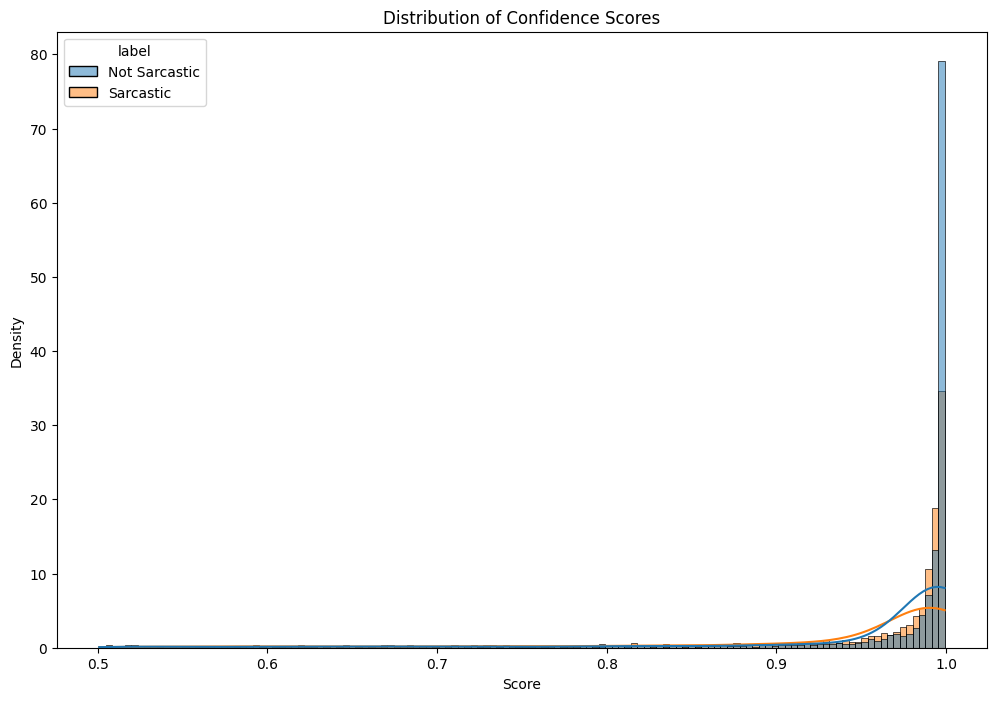

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))

scores = [p['score'] for p in pred]
labels = [label_map[p['label']] for p in pred]

sns.histplot(data={'score': scores, 'label': labels}, x='score', hue='label', kde=True, stat='density')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()


From this graph we can see how many not sarcastic headliens are correctly predited, while we still have a high even if lower number of sarcastic headlines predicted

It is possible to try our Sarcarstic headline detection here: https://huggingface.co/PietroSaveri/Sarcastic_01


*NOTE:*
*   0 = Not Sarcastic
*   1 = Sarcastic

